# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements_2.txt

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!jupyter --version

jupyter core     : 4.6.3
jupyter-notebook : 5.7.4
qtconsole        : 5.4.4
ipython          : 7.13.0
ipykernel        : 5.1.4
jupyter client   : 6.0.0
jupyter lab      : 1.0.9
nbconvert        : 5.6.1
ipywidgets       : 8.1.1
nbformat         : 5.0.4
traitlets        : 4.3.3


## Imports

In [4]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [6]:
# Define transforms - Data is preprocessed and converted to a tensor, either using the .ToTensor() transform from torchvision.transforms or simply manually with torch.Tensor.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]) # 1 channel grayscale not 3 channels

# A DataLoader object for both train and test sets is created using the train and test sets loaded from torchvision.

# Define train and test data
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Define train and test loaders
train_loader = DataLoader(train_data, batch_size=28, shuffle=True)
test_loader = DataLoader(test_data, batch_size=28)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

Normalization is a process of scaling the input data to a common range. It is a common practice to normalize the input data before feeding it to a neural network. The primary reason for normalization is to ensure that the input features are on a similar scale, which helps to stabilize the gradient descent step, allowing us to use larger learning rates or help models converge faster for a given learning rate.

If the input variables are combined linearly, as in a multilayer perceptron (MLP), then it is rarely strictly necessary to standardize the inputs, at least in theory. However, there are a variety of practical reasons why standardizing the inputs can make training faster and reduce the chances of getting stuck in local optima. Also, weight decay and Bayesian estimation can be done more conveniently with standardized inputs.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [7]:
# This cell contains a function for showing 5 images from a dataloader
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

8


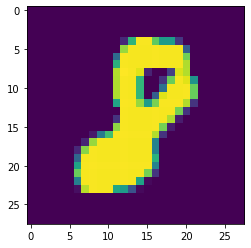

3


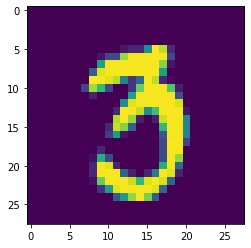

3


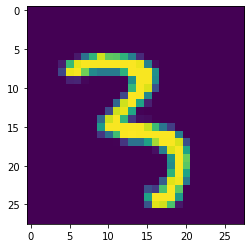

0


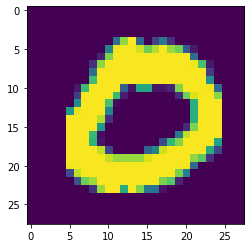

7


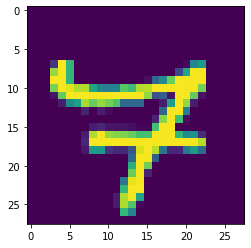

6


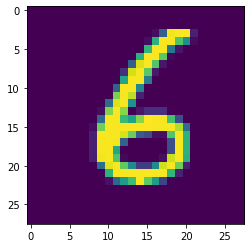

5


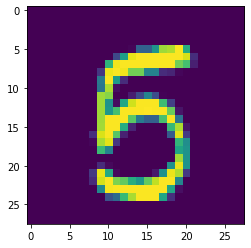

1


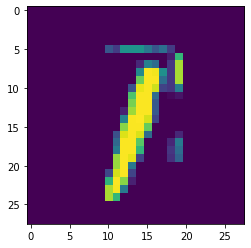

3


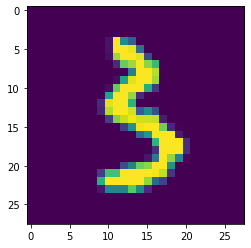

0


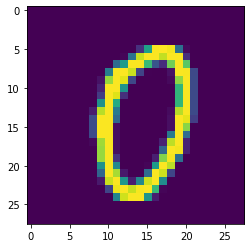

In [8]:
# Explore data - Notebook contains code which shows the size and shape of the training and test data
transform_raw = transforms.Compose([transforms.ToTensor()])

training_data_raw = datasets.MNIST(root="data", train=True, download=True, transform = transform_raw)
train_loader_raw = DataLoader(training_data_raw, batch_size=32, shuffle=True)

show5(train_loader_raw)

testing_data_raw = datasets.MNIST(root="data", train=True, download=True, transform = transform_raw)
test_loader_raw = DataLoader(testing_data_raw, batch_size=32, shuffle=True)

show5(test_loader_raw)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [9]:
# Build Model

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # define activation function
        self.activation = F.relu
        # define dropout
        self.dropout = nn.Dropout(p=0.5) # dropout implemented as a layer p is the probablity we set for zeroing out a neuron
        # define layers
        self.fc1 = nn.Linear(28 * 28 * 1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # flatten all dimensions except batch
        x = self.dropout(x) # can use wherever we like since no input or output size requirements
        x = torch.flatten(x, 1)
        # feed forward
        x = self.activation(self.fc1(x))
        x = self.dropout(x) # can use wherever we like since no input or output size requirements
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()
net.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 torch.Size([120, 784])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])


Flatting Explained:

It would be more complicated and less efficient to get the same result without reshaping first, that's why we always do it before a fully connected layer. Because when you're adding a fully connected layer, you always want your data to be a (1 or) 2 dimensional matrix, where each row is the vector representing your data. That way, the fully connected layer is just a matrix multiplicationx = torch.flatten(x, 1). Additionally by defining the layer like this we can efficiently calculate the next step by calculating the formula: f(Wx + b) = y. This would not be as easily possible with multidimensional input and reshaping the input is low cost and easy to accomplish. 

Flattening is a process of converting the data into a 1-dimensional array for inputting it to the next layer. In some architectures, such as Convolutional Neural Networks (CNN), an image is better processed by a neural network if it is in 1D form rather than 2D. The Flatten layer is a valuable tool in neural network architectures for transitioning from convolutional or spatially structured data to fully connected layers 3. Its advantages include simplicity, compatibility, and dimensionality reduction 3.

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [10]:
# specify optimizer to minimise the loss function
optimizer = optim.Adam(net.parameters(), lr=0.001) # lr is learning rate

# could also use SGD e.g. optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# specify loss function
criterion = nn.CrossEntropyLoss()

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'params': [0, 1, 2, 3, 4, 5]}]


Why the chosen loss function?

The cross-entropy loss function is commonly used for classification tasks. It is a computationally feasible loss function that represents the price paid for inaccuracy of predictions in classification problems. The loss function quantifies the difference between the predicted outputs of a machine learning algorithm and the actual target values. It is intended for use with binary classification where the target values are in the set {0, 1}. Mathematically, it is the preferred loss function under the inference framework of maximum likelihood.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
# Train Model Function
train_loss_history = list()
val_loss_history = list()
    
def train_model(net, optimizer, criterion, train_loader, num_epochs):
    
    best_val_loss = float('inf') # sets best val loss to infinity as starting point since monitoring for improvement later
    threshold = 0.001 # set threshold for min performence improvement
    below_threshold = 0 # sets starting point for how many times fallen below threshold
    patience = 2 # sets how many epochs to allow for performance to fall below threshold

    for epoch in range(num_epochs):

        net.train() # trains model
        train_loss = 0.0 # sets startin point of epoch loss to zero
        train_correct = 0 # sets number of correct predictions to starting point of zero

        for i, data in enumerate(train_loader): # enumerate to keep track of the batches we've iterated over
            
            inputs, labels = data # to get the inputs and labels within batch, i
            inputs, labels = inputs.to(device), labels.to(device) # to cuda or cpu, see start of notebook   
            optimizer.zero_grad() # Zeros out the gradients of the optimizer
            outputs = net(inputs) # Get the outputs from the model
            loss = criterion(outputs, labels) # computes the loss in the context of our criterion
            loss.backward() # Compute the gradient of the loss with respect to the parameters using the backward method
            optimizer.step() # updates the parameters by taking a step with the optimizer
            
            _, preds = torch.max(outputs.data, 1) # gets predictions from the outputs, 1 is the axis to look at
            train_correct += (preds == labels).sum().item() # update the number of correct training examples
            train_loss += loss.item() # update the running loss for the epoch

        print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
        
        train_loss_history.append(train_loss/len(train_loader))

        # perform validation
        
        val_loss = 0.0 # sets validation loss
        val_correct = 0
        net.eval() # set to eval so we're not computing the gradients of the inputs
        
        for inputs, labels in train_loader: # or could instead use a 'validation_loader' if using 3 way split, note tutorials used test loader here

            inputs, labels = inputs.to(device), labels.to(device) # to cuda or cpu, see start of notebook 
            outputs = net(inputs) # compute outputs
            loss = criterion(outputs, labels) # compute loss
            _, preds = torch.max(outputs.data, 1) # compute predictions
            val_correct += (preds == labels).sum().item() # calculate number of correct predictions
            val_loss += loss.item() # updates the validation loss with the loss for the batch

        print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(train_loader):.2f}% validation loss: {val_loss/len(train_loader):.5f}')
        
        val_loss_history.append(val_loss/len(train_loader))

        diff = best_val_loss - val_loss # calulates the difference between the best val loss and the val loss

        # sets the best val loss to the current loss if smaller
        if best_val_loss > val_loss:
            best_val_loss = val_loss

        # if patience exceeded breaks training
        if diff <= threshold:
            below_threshold += 1
            if below_threshold > patience:
                break

In [12]:
# Train the model
train_model(net, optimizer, criterion, train_loader, num_epochs = 10)

Epoch 1 training accuracy: 21.22% training loss: 0.73358
Epoch 1 validation accuracy: 25.59% validation loss: 0.28979
Epoch 2 training accuracy: 22.98% training loss: 0.55251
Epoch 2 validation accuracy: 26.01% validation loss: 0.24411
Epoch 3 training accuracy: 23.43% training loss: 0.50400
Epoch 3 validation accuracy: 26.15% validation loss: 0.23146
Epoch 4 training accuracy: 23.62% training loss: 0.48486
Epoch 4 validation accuracy: 26.31% validation loss: 0.21121
Epoch 5 training accuracy: 23.77% training loss: 0.47268
Epoch 5 validation accuracy: 26.46% validation loss: 0.20218
Epoch 6 training accuracy: 23.87% training loss: 0.45788
Epoch 6 validation accuracy: 26.57% validation loss: 0.18785
Epoch 7 training accuracy: 23.96% training loss: 0.44703
Epoch 7 validation accuracy: 26.60% validation loss: 0.18574
Epoch 8 training accuracy: 24.02% training loss: 0.44154
Epoch 8 validation accuracy: 26.68% validation loss: 0.17125
Epoch 9 training accuracy: 24.11% training loss: 0.43254

Plot the training loss (and validation loss/accuracy, if recorded).

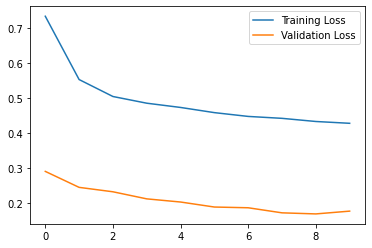

In [13]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

Epoch 1 test accuracy: 26.60% validation loss: 0.17520
Epoch 2 test accuracy: 26.60% validation loss: 0.17520
Epoch 3 test accuracy: 26.60% validation loss: 0.17520
Epoch 4 test accuracy: 26.60% validation loss: 0.17520
Epoch 5 test accuracy: 26.60% validation loss: 0.17520
Epoch 6 test accuracy: 26.60% validation loss: 0.17520
Epoch 7 test accuracy: 26.60% validation loss: 0.17520
Epoch 8 test accuracy: 26.60% validation loss: 0.17520
Epoch 9 test accuracy: 26.60% validation loss: 0.17520
Epoch 10 test accuracy: 26.60% validation loss: 0.17520


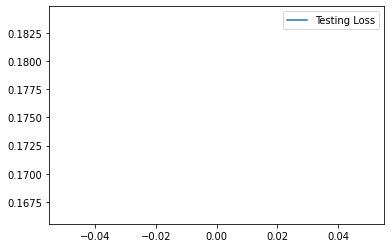

In [14]:
# perform test

num_epochs = 10

for epoch in range(num_epochs):

    test_loss = 0.0 # sets validation loss
    test_correct = 0
    net.eval()
    test_loss_history = list()

    for inputs, labels in test_loader:

        inputs, labels = inputs.to(device), labels.to(device) # to cuda or cpu, see start of notebook 
        outputs = net(inputs) # compute outputs
        loss = criterion(outputs, labels) # compute loss
        _, preds = torch.max(outputs.data, 1) # compute predictions
        test_correct += (preds == labels).sum().item() # calculate number of correct predictions
        test_loss += loss.item() # updates the validation loss with the loss for the batch

    print(f'Epoch {epoch + 1} test accuracy: {test_correct/len(test_loader):.2f}% validation loss: {test_loss/len(test_loader):.5f}')

    test_loss_history.append(test_loss/len(test_loader))

plt.plot(test_loss_history, label="Testing Loss")
plt.legend()
plt.show()

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [15]:
## YOUR CODE HERE ##
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# specify loss function
criterion = nn.CrossEntropyLoss()

train_model(net, optimizer, criterion, train_loader, num_epochs = 10)

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 1e-05, 'nesterov': False, 'maximize': False, 'params': [0, 1, 2, 3, 4, 5]}]
Epoch 1 training accuracy: 23.39% training loss: 0.54257
Epoch 1 validation accuracy: 26.43% validation loss: 0.20357
Epoch 2 training accuracy: 23.52% training loss: 0.53316
Epoch 2 validation accuracy: 26.15% validation loss: 0.24165
Epoch 3 training accuracy: 23.63% training loss: 0.52478
Epoch 3 validation accuracy: 26.33% validation loss: 0.23002
Epoch 4 training accuracy: 23.61% training loss: 0.52350
Epoch 4 validation accuracy: 26.50% validation loss: 0.21574


## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
torch.save

<function torch.serialization.save(obj, f: Union[str, os.PathLike, BinaryIO, IO[bytes]], pickle_module=<module 'pickle' from '/opt/conda/lib/python3.7/pickle.py'>, pickle_protocol=2, _use_new_zipfile_serialization=True) -> None>